# Datasets description

En este trabajo se consideran tres tipos de fuentes de datos, cada una con un propósito específico dentro del marco metodológico: dataset sintético, datasets benchmark y dataset de datos reales provenientes de dispositivos comerciales.

## 1. Dataset sintético

El dataset sintético fue diseñado y generado específicamente para esta investigación. Su objetivo principal es proporcionar un entorno controlado que permita:
	•	Probar hipótesis bajo condiciones bien definidas.
	•	Realizar pruebas preliminares de consistencia y estabilidad de las arquitecturas propuestas.

Características principales:
	•	Variables simuladas inspiradas en señales fisiológicas (frecuencia cardiaca, respiratoria, temperatura, actividad, etc.).
	•	Inclusión intencional de patrones de irregularidad y faltantes no aleatorios, para reflejar condiciones típicas en datos médicos reales.
	•	Escenarios configurables: número de sujetos, longitud de las series, proporción de ruido y de artefactos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

# Paths (ajusta si tu notebook tiene otra ruta)
PATH_SLEEP = "/home/gmartinez/Tesis/Datasets/Synthetic-data/outputs/300/sleep_series.csv"
PATH_PROF  = "/home/gmartinez/Tesis/Datasets/Synthetic-data/outputs/300/user_profiles.csv"
PATH_LAB   = "/home/gmartinez/Tesis/Datasets/Synthetic-data/outputs/300/nightly_labeled.csv"   # tiene etiqueta y threshold
PATH_SCORE = "/home/gmartinez/Tesis/Datasets/Synthetic-data/outputs/300/scored_labeled.csv"    # tiene recovery_score_0_1

sleep = pd.read_csv(PATH_SLEEP, parse_dates=["night_date"])
prof  = pd.read_csv(PATH_PROF)
lab   = pd.read_csv(PATH_LAB, parse_dates=["night_date"])
score = pd.read_csv(PATH_SCORE, parse_dates=["night_date"])

# Unificamos en una tabla "night-level" con score + label
df = sleep.merge(score[["user_id","night_date","recovery_score_0_1"]],
                 on=["user_id","night_date"], how="left") \
          .merge(lab[["user_id","night_date","recovery_threshold","recovery_label_binary"]],
                 on=["user_id","night_date"], how="left")

# Limpieza de etiqueta (por si viene como string)
def label_to_int(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, np.integer, float, np.floating)):
        return int(x)
    x = str(x).strip().lower()
    if "adequate" in x:
        return 1
    if "deficient" in x:
        return 0
    return np.nan

df["y"] = df["recovery_label_binary"].apply(label_to_int)

# Orden temporal
df = df.sort_values(["user_id","night_date"]).reset_index(drop=True)

print("Rows (nights):", len(df))
print("Users:", df["user_id"].nunique())
print(df.columns.tolist())

Rows (nights): 28741
Users: 300
['user_id', 'night_date', 'total_hours', 'deep_minutes', 'rem_minutes', 'awake_minutes', 'sleep_latency_minutes', 'awakenings', 'failure_minutes', 'recovery_score_0_1', 'recovery_threshold', 'recovery_label_binary', 'y']


In [2]:
n_nights_per_user = df.groupby("user_id")["night_date"].count().sort_values(ascending=False)
example_user = int(n_nights_per_user.index[0])

print("Example user:", example_user, "| nights:", int(n_nights_per_user.iloc[0]))

u = df[df["user_id"] == example_user].copy()
u_prof = prof[prof["user_id"] == example_user].iloc[0].to_dict()
u.head()

Example user: 72 | nights: 281


,user_id,night_date,total_hours,deep_minutes,rem_minutes,awake_minutes,sleep_latency_minutes,awakenings,failure_minutes,recovery_score_0_1,recovery_threshold,recovery_label_binary,y
6397,72,2024-01-01,6.850000,179,35,87,1,39,34,0.354000,0.350502,Adequate Recovery,1
6398,72,2024-01-02,7.116667,150,26,108,1,50,42,0.364667,0.350502,Adequate Recovery,1
6399,72,2024-01-03,6.583333,155,35,80,1,30,50,0.343333,0.350502,Deficient Recovery,0
6400,72,2024-01-04,6.483333,104,27,111,6,40,13,0.315086,0.350502,Deficient Recovery,0
6401,72,2024-01-06,7.050000,130,43,114,5,44,42,0.362794,0.350502,Adequate Recovery,1


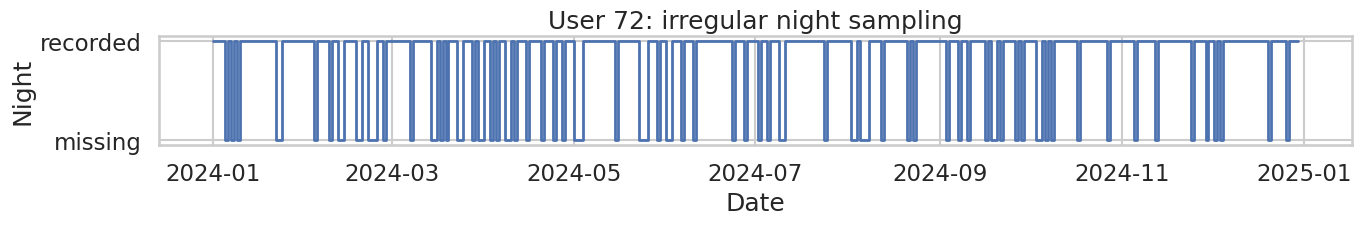

In [3]:
def plot_irregularity(u, title="Irregular sampling across nights"):
    dates = pd.to_datetime(u["night_date"]).sort_values()
    all_days = pd.date_range(dates.min(), dates.max(), freq="D")
    present = pd.Series(0, index=all_days)
    present.loc[dates.dt.normalize().unique()] = 1

    fig, ax = plt.subplots(figsize=(14, 2.6))
    ax.plot(present.index, present.values, drawstyle="steps-post", linewidth=2)
    ax.set_yticks([0,1])
    ax.set_yticklabels(["missing", "recorded"])
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Night")
    plt.tight_layout()
    return fig

plot_irregularity(u, title=f"User {example_user}: irregular night sampling")
plt.show()

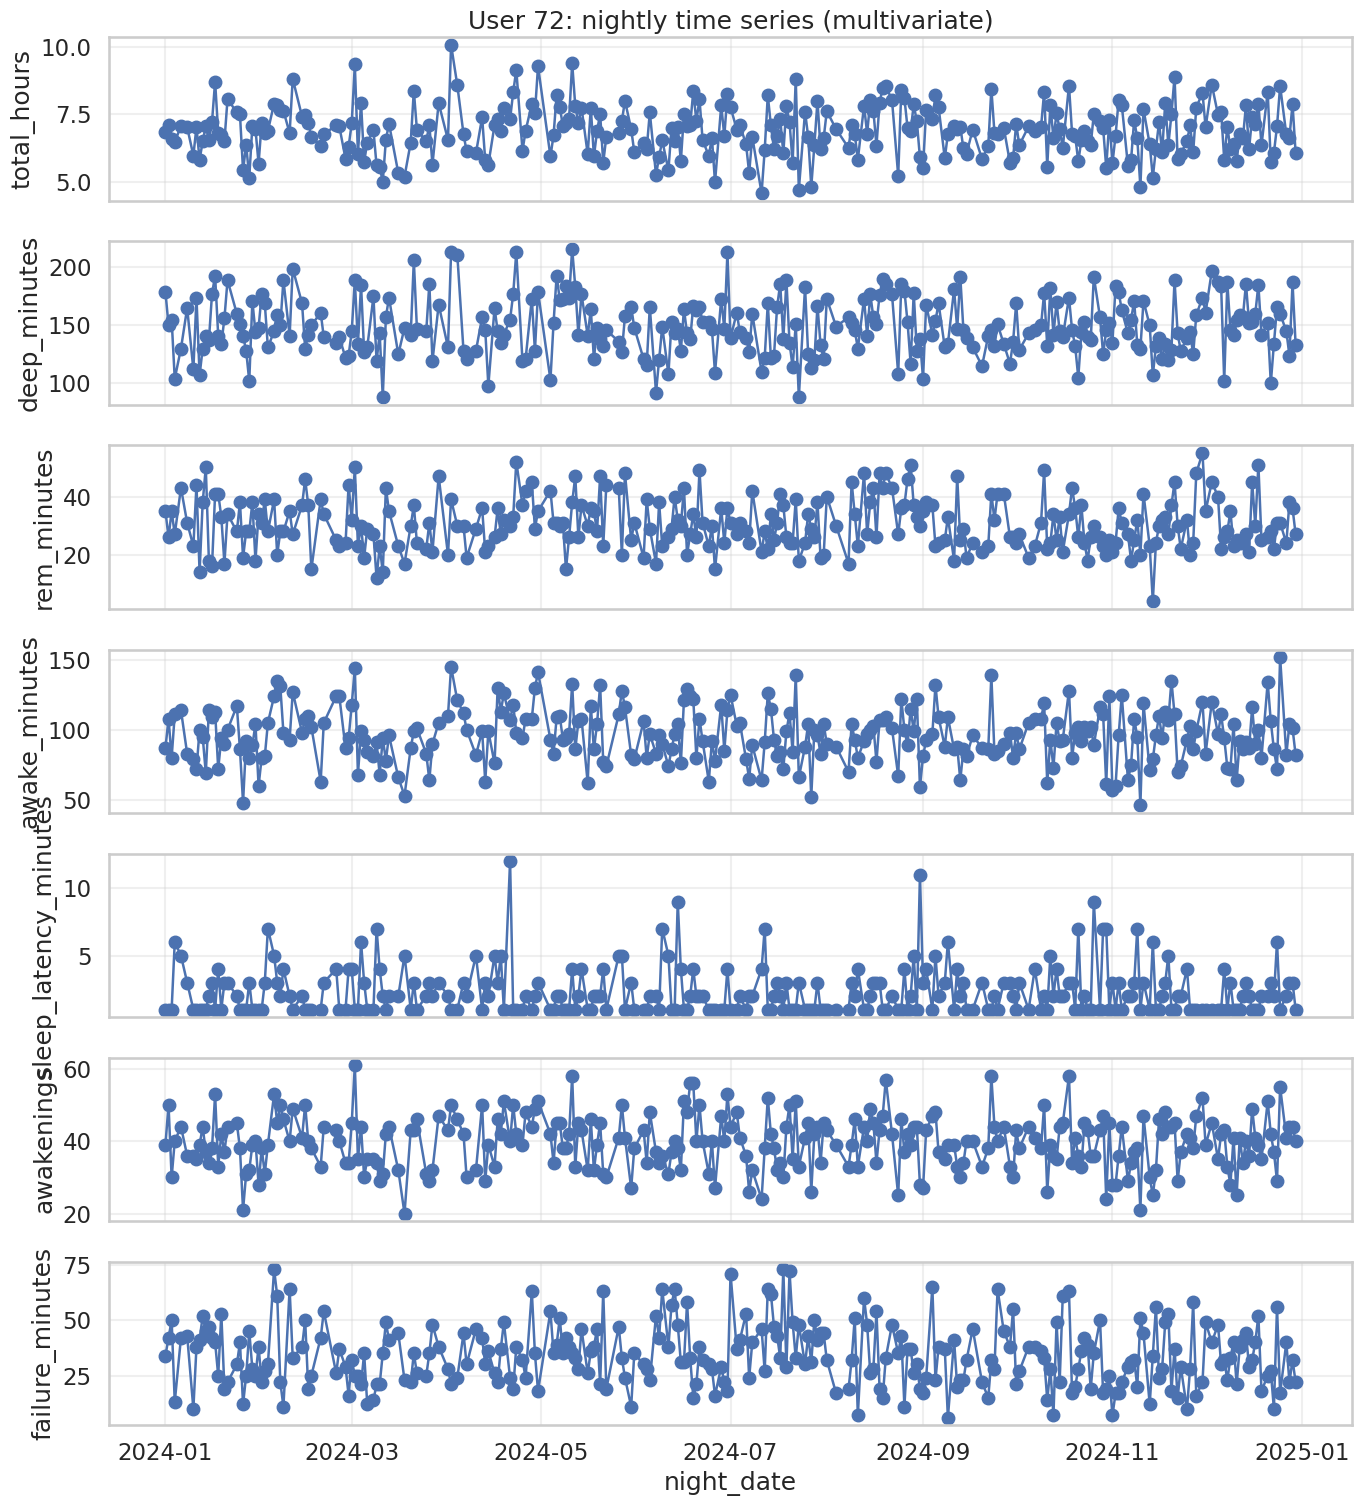

In [4]:
vars_to_plot = [
    "total_hours",
    "deep_minutes",
    "rem_minutes",
    "awake_minutes",
    "sleep_latency_minutes",
    "awakenings",
    "failure_minutes",
]

def plot_user_multivariate(u, vars_to_plot, title):
    n = len(vars_to_plot)
    fig, axes = plt.subplots(n, 1, figsize=(14, 2.2*n), sharex=True)
    if n == 1:
        axes = [axes]

    for ax, col in zip(axes, vars_to_plot):
        ax.plot(u["night_date"], u[col], marker="o", linewidth=1.8)
        ax.set_ylabel(col)
        ax.grid(True, alpha=0.3)

    axes[0].set_title(title)
    axes[-1].set_xlabel("night_date")
    plt.tight_layout()
    return fig

plot_user_multivariate(u, vars_to_plot, title=f"User {example_user}: nightly time series (multivariate)")
plt.show()

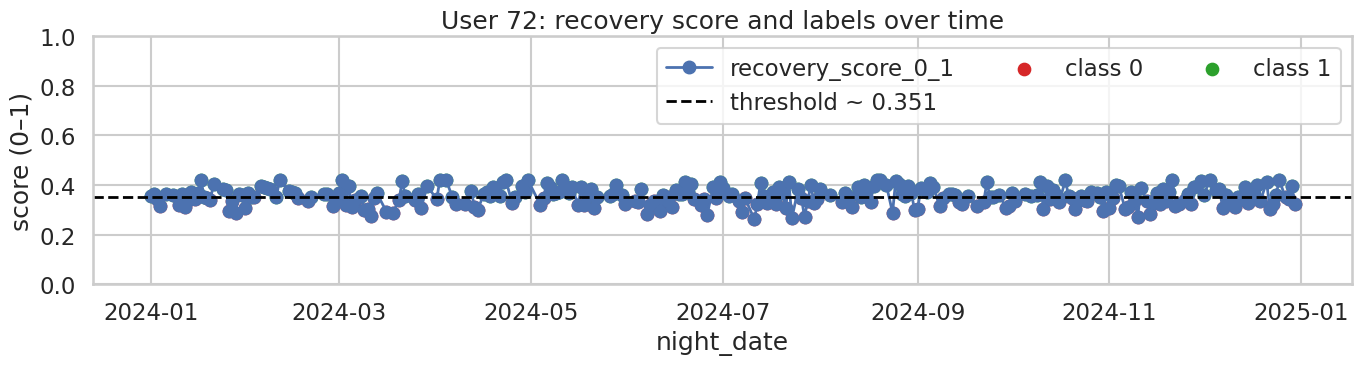

In [5]:
def plot_score_and_label(u, title):
    fig, ax = plt.subplots(figsize=(14, 4))

    ax.plot(u["night_date"], u["recovery_score_0_1"], marker="o", linewidth=2, label="recovery_score_0_1")

    # threshold (puede variar por noche o ser constante; tomamos mediana ignorando NaNs)
    thr = np.nanmedian(u["recovery_threshold"].values)
    if np.isfinite(thr):
        ax.axhline(thr, color="black", linestyle="--", linewidth=2, label=f"threshold ~ {thr:.3f}")

    # sombreado por clase (si existe)
    if u["y"].notna().any():
        # colorea puntos por clase
        palette = {0: "#d62728", 1: "#2ca02c"}
        for yval, g in u.dropna(subset=["y"]).groupby("y"):
            ax.scatter(g["night_date"], g["recovery_score_0_1"], s=70, color=palette[int(yval)], label=f"class {int(yval)}")

    ax.set_ylim(0, 1)
    ax.set_title(title)
    ax.set_xlabel("night_date")
    ax.set_ylabel("score (0–1)")
    ax.legend(ncol=3, frameon=True)
    plt.tight_layout()
    return fig

plot_score_and_label(u, title=f"User {example_user}: recovery score and labels over time")
plt.show()

In [6]:
def format_profile_card(d):
    keys = ["age", "age_group", "gender", "physical_activity_level", "smoking_status",
            "alcohol_consumption", "diabetes", "hypertension"]
    lines = [f"{k}: {d.get(k)}" for k in keys if k in d]
    return "\n".join(lines)

print("User profile\n------------")
print(format_profile_card(u_prof))

User profile
------------
age: 29
age_group: young
gender: female
physical_activity_level: sedentary
smoking_status: non_smoker
alcohol_consumption: high
diabetes: no
hypertension: no


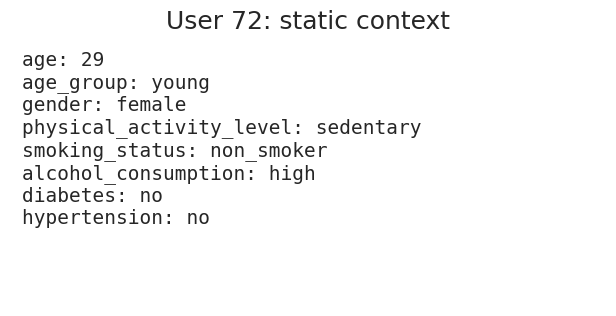

In [7]:
def plot_profile_card(d, title="Context (static profile)"):
    fig, ax = plt.subplots(figsize=(6.5, 3.5))
    ax.axis("off")
    ax.set_title(title)
    ax.text(0.02, 0.95, format_profile_card(d), va="top", ha="left", fontsize=14, family="monospace")
    plt.tight_layout()
    return fig

plot_profile_card(u_prof, title=f"User {example_user}: static context")
plt.show()

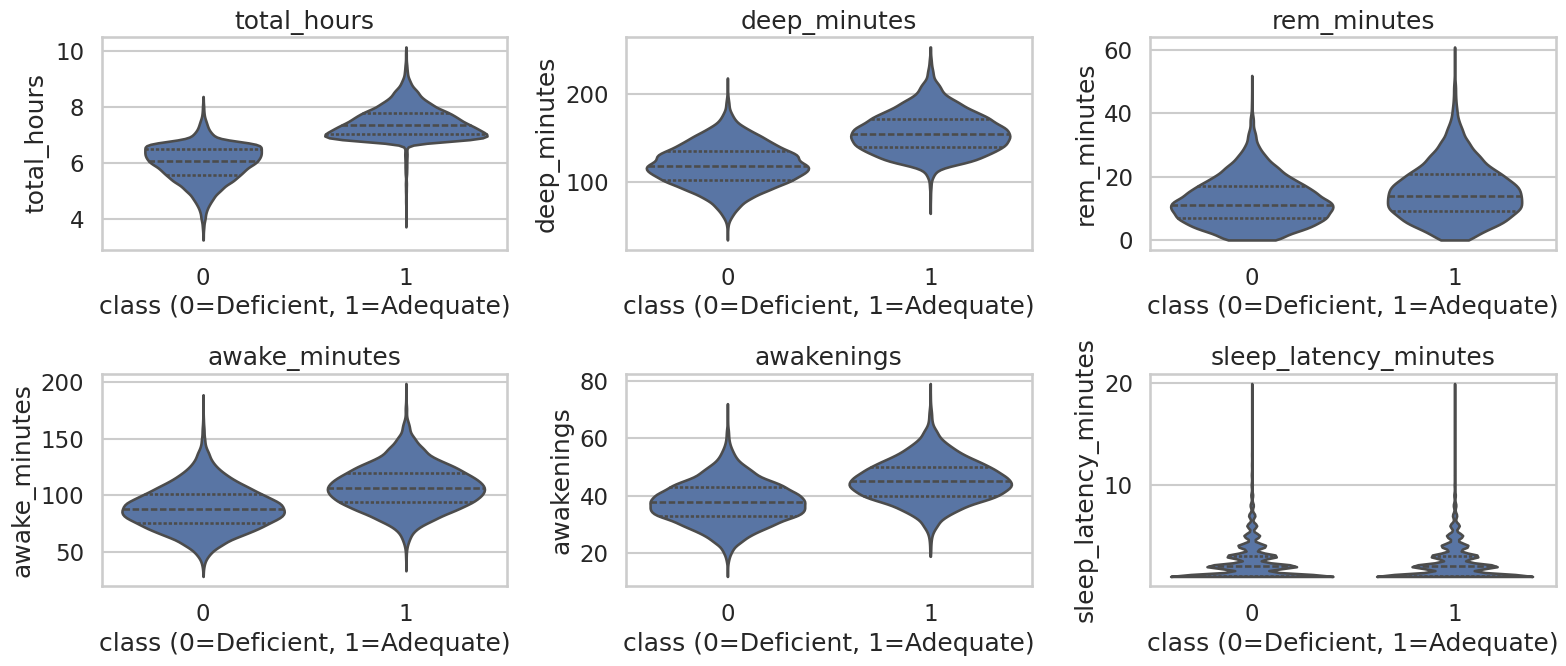

In [8]:
# Selecciona filas con clase disponible
df_lab = df.dropna(subset=["y"]).copy()
df_lab["y"] = df_lab["y"].astype(int)

features_for_dist = ["total_hours", "deep_minutes", "rem_minutes", "awake_minutes", "awakenings", "sleep_latency_minutes"]

def plot_distributions_by_class(df_lab, features):
    n = len(features)
    fig, axes = plt.subplots(2, int(np.ceil(n/2)), figsize=(16, 7))
    axes = axes.flatten()

    for ax, col in zip(axes, features):
        sns.violinplot(data=df_lab, x="y", y=col, ax=ax, inner="quartile", cut=0)
        ax.set_title(col)
        ax.set_xlabel("class (0=Deficient, 1=Adequate)")
    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    return fig

plot_distributions_by_class(df_lab, features_for_dist)
plt.show()

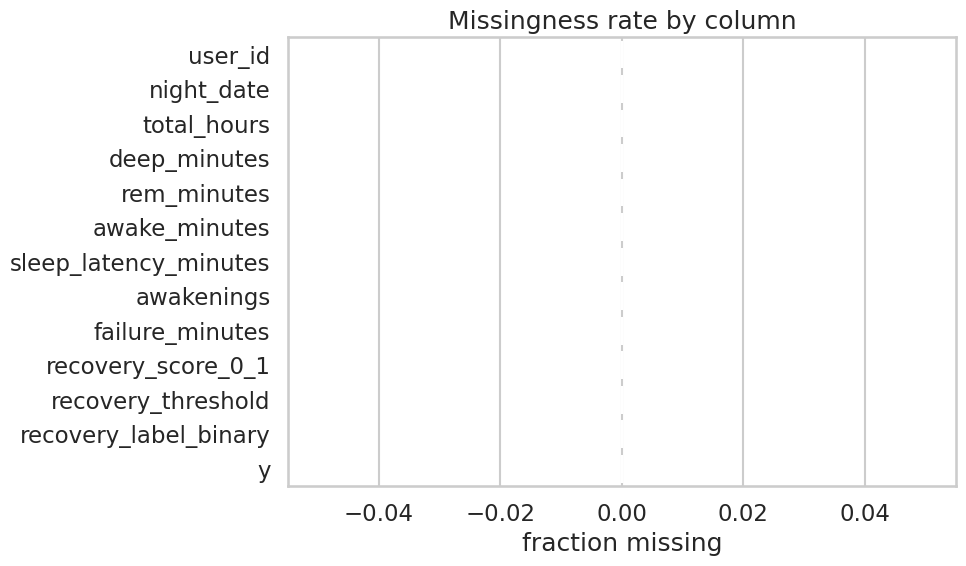

In [9]:
def plot_missingness(df):
    miss = df.isna().mean().sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=miss.values, y=miss.index, ax=ax, color="#4c72b0")
    ax.set_title("Missingness rate by column")
    ax.set_xlabel("fraction missing")
    ax.set_ylabel("")
    plt.tight_layout()
    return fig

plot_missingness(df)
plt.show()

## 2. Datasets benchmark

Se emplean dos fuentes de datos de acceso público ampliamente reconocidas en la literatura que aportan rigor científico y comparabilidad con otros trabajos:

a) Sleep Heart Health Study (SHHS)
	•	Estudio longitudinal multicéntrico de sueño con registros de polisomnografía en miles de participantes.
	•	Variables principales: frecuencia cardiaca, respiratoria, saturación de oxígeno, movimientos torácicos y abdominales, entre otras.
	•	Cobertura de noches completas, lo cual permite analizar patrones fisiológicos de larga duración.
	•	Relevancia: dataset ampliamente utilizado en tareas de detección de apnea del sueño y análisis de señales biomédicas.

b) MIMIC-III (Medical Information Mart for Intensive Care)
	•	Base de datos de cuidados intensivos que contiene información clínica de pacientes hospitalizados en el Beth Israel Deaconess Medical Center.
	•	Variables: signos vitales, registros de laboratorio, prescripciones y notas clínicas.
	•	Incluye datos irregulares y heterogéneos, reflejando las condiciones reales de monitoreo en UCI.
	•	Relevancia: uno de los recursos estándar para la investigación en machine learning aplicado a salud.


## 3. Dataset de datos reales (wearables comerciales)

Se considera un conjunto de datos recolectados a partir de las ocho marcas de wearables más comerciales en la actualidad (ej. Apple, Samsung, Fitbit, Garmin, Xiaomi, Huawei, Amazfit, Polar). Estos dispositivos generan registros continuos de señales fisiológicas y de actividad.

Características principales:
	•	Variables registradas: frecuencia cardiaca, frecuencia respiratoria (en algunos modelos), temperatura cutánea, nivel de oxigenación, patrones de sueño, pasos y gasto energético estimado.
	•	Alta variabilidad en la calidad y frecuencia de muestreo, dependiendo del fabricante y del modelo.
	•	Presencia significativa de datos faltantes y desalineación temporal entre dispositivos.
	•	Relevancia: proporciona una perspectiva de datos en condiciones naturales, reflejando hábitos de la vida cotidiana fuera del entorno clínico.
